In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

In [2]:
my_data_dir = 'new'

In [4]:
# CONFIRM THAT THIS REPORTS BACK 'test', and 'train'
os.listdir(my_data_dir) 

['test', 'train']

In [5]:
test_path = my_data_dir+'/test/'
train_path = my_data_dir+'/train/'

In [6]:
os.listdir(test_path)

['Parasitized', 'Unifected']

In [7]:
os.listdir(train_path)

['Parasitized', 'Uninfected']

In [8]:
os.listdir(train_path+'parasitized')[0]

'C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [9]:
para_cell = train_path+'/parasitized'+'/C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [10]:
para_img= imread(para_cell)

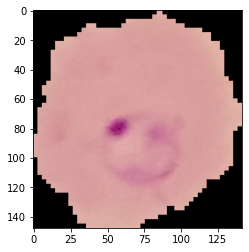

In [11]:
plt.imshow(para_img)

In [12]:
para_img.shape

(148, 142, 3)

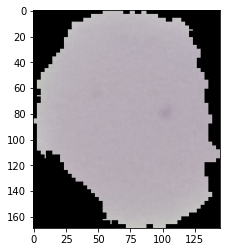

In [13]:
unifected_cell_path = train_path+'/uninfected/'+os.listdir(train_path+'/uninfected')[0]
unifected_cell = imread(unifected_cell_path)
plt.imshow(unifected_cell)

**Let's check how many images there are.**

In [14]:
len(os.listdir(train_path+'/parasitized'))

8407

In [15]:
len(os.listdir(train_path+'/uninfected'))

6020

**Let's find out the average dimensions of these images.**

In [16]:
unifected_cell.shape

(169, 145, 3)

In [17]:
para_img.shape

(148, 142, 3)

In [23]:
test_path = my_data_dir+'/test'
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'/Unifected'):
    
    img = imread(test_path+'/Unifected'+'/'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

F:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


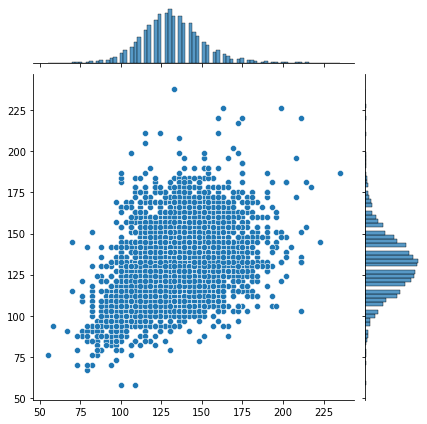

In [24]:
sns.jointplot(dim1,dim2)

In [25]:
np.mean(dim1)

131.4911082474227

In [26]:
np.mean(dim2)

130.99664948453608

In [27]:
image_shape = (130,130,3)

## Preparing the Data for the model

There is too much data for us to read all at once in memory. We can use some built in functions in Keras to automatically process the data, generate a flow of batches from a directory, and also manipulate the images.

### Image Manipulation

Its usually a good idea to manipulate the images with rotation, resizing, and scaling so the model becomes more robust to different images that our data set doesn't have. We can use the **ImageDataGenerator** to do this automatically for us. Check out the documentation for a full list of all the parameters you can use here!

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [29]:
help(ImageDataGenerator)

Help on class ImageDataGenerator in module keras.preprocessing.image:

class ImageDataGenerator(builtins.object)
 |  ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None, validation_split=0.0, interpolation_order=1, dtype=None)
 |  
 |  Generate batches of tensor image data with real-time data augmentation.
 |  
 |  Deprecated: `tf.keras.preprocessing.image.ImageDataGenerator` is not
 |  recommended for new code. Prefer loading images with
 |  `tf.keras.utils.image_dataset_from_directory` and transforming the output
 |  `tf.data.Dataset` with preprocessing layers. For more informati

In [30]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

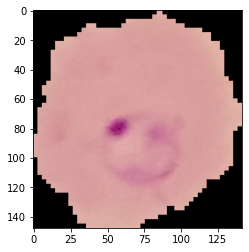

In [31]:
plt.imshow(para_img)

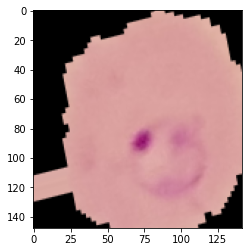

In [32]:
plt.imshow(image_gen.random_transform(para_img))

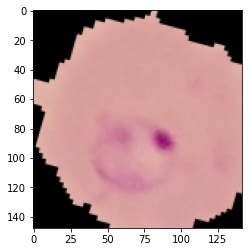

In [33]:
plt.imshow(image_gen.random_transform(para_img))

In [34]:
image_gen.flow_from_directory(train_path)

Found 14426 images belonging to 2 classes.


In [35]:
image_gen.flow_from_directory(test_path)

Found 13132 images belonging to 2 classes.


# Creating the Model

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [37]:
#https://stats.stackexchange.com/questions/148139/rules-for-selecting-convolutional-neural-network-hyperparameters
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model.add(Dropout(0.5))

# Last layer, remember its binary so we use sigmoid
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

## Early Stopping

In [39]:
from tensorflow.keras.callbacks import EarlyStopping

In [40]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

## Training the Model

In [41]:
help(image_gen.flow_from_directory)

Help on method flow_from_directory in module keras.preprocessing.image:

flow_from_directory(directory, target_size=(256, 256), color_mode='rgb', classes=None, class_mode='categorical', batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='png', follow_links=False, subset=None, interpolation='nearest', keep_aspect_ratio=False) method of keras.preprocessing.image.ImageDataGenerator instance
    Takes the path to a directory & generates batches of augmented data.
    
    Args:
        directory: string, path to the target directory. It should contain
          one subdirectory per class. Any PNG, JPG, BMP, PPM or TIF images
          inside each of the subdirectories directory tree will be included
          in the generator. See [this script](
          https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d)
          for more details.
        target_size: Tuple of integers `(height, width)`, defaults to `(256,
          256)`. The dimensions

In [42]:
batch_size = 16

In [43]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 14426 images belonging to 2 classes.


In [44]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 13132 images belonging to 2 classes.


In [45]:
train_image_gen.class_indices

{'Parasitized': 0, 'Uninfected': 1}

In [46]:
import warnings
warnings.filterwarnings('ignore')

In [48]:
results = model.fit_generator(train_image_gen,epochs=5,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

Epoch 1/5
902/902 [==============================] - 253s 280ms/step - loss: 0.4749 - accuracy: 0.7829 - val_loss: 0.3647 - val_accuracy: 0.8818
Epoch 2/5
902/902 [==============================] - 243s 270ms/step - loss: 0.1993 - accuracy: 0.9371 - val_loss: 0.2620 - val_accuracy: 0.9103
Epoch 3/5
902/902 [==============================] - 242s 268ms/step - loss: 0.1823 - accuracy: 0.9454 - val_loss: 0.4772 - val_accuracy: 0.8265
Epoch 4/5
902/902 [==============================] - 240s 266ms/step - loss: 0.1791 - accuracy: 0.9437 - val_loss: 0.2624 - val_accuracy: 0.9051


# New Section

In [49]:
from tensorflow.keras.models import load_model
model.save('malaria.h5')
# model.save('./drive/My Drive/malaria_detector.h5')

# Evaluating the Model

In [50]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

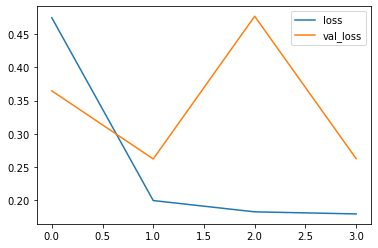

In [51]:
losses[['loss','val_loss']].plot()

In [52]:
model.metrics_names

['loss', 'accuracy']

In [53]:
model.evaluate_generator(test_image_gen)

[0.26734110713005066, 0.9051172733306885]

In [54]:
from tensorflow.keras.preprocessing import image

In [55]:

pred_probabilities = model.predict_generator(test_image_gen)

In [56]:
pred_probabilities

array([[1.2659708e-06],
       [6.8613362e-01],
       [6.7028689e-09],
       ...,
       [9.4807690e-01],
       [9.4306958e-01],
       [9.5387137e-01]], dtype=float32)

In [57]:
test_image_gen.classes

array([0, 0, 0, ..., 1, 1, 1])

In [58]:
predictions = pred_probabilities > 0.5

In [59]:
# Numpy can treat this as True/False for us
predictions

array([[False],
       [ True],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [60]:
from sklearn.metrics import classification_report,confusion_matrix

In [61]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.85      0.92      0.89      5372
           1       0.94      0.89      0.92      7760

    accuracy                           0.90     13132
   macro avg       0.90      0.91      0.90     13132
weighted avg       0.91      0.90      0.90     13132



In [62]:
confusion_matrix(test_image_gen.classes,predictions)

array([[4964,  408],
       [ 856, 6904]], dtype=int64)

# Predicting on an Image

In [63]:
para_cell

'new/train//parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [64]:
my_image = image.load_img(para_cell,target_size=image_shape)

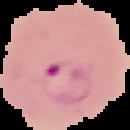

In [65]:
my_image

In [66]:
type(my_image)

PIL.Image.Image

In [67]:
my_image = image.img_to_array(my_image)

In [68]:
type(my_image)

numpy.ndarray

In [69]:
my_image.shape

(130, 130, 3)

In [70]:
my_image = np.expand_dims(my_image, axis=0)

In [71]:
my_image.shape

(1, 130, 130, 3)

In [72]:
model.predict(my_image)

1/1 [==============================] - 0s 78ms/step


array([[0.]], dtype=float32)

In [73]:
train_image_gen.class_indices

{'Parasitized': 0, 'Uninfected': 1}

In [74]:
test_image_gen.class_indices

{'Parasitized': 0, 'Unifected': 1}